# Sentinel-1 Median Composite
<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/S1image.PNG" />

[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube) This product creates a median composite of Sentinel-1 VV and VH bands.



## Import required modules

In [1]:
# jupyteronly
%matplotlib inline
import datacube

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube_utilities.interactive_maps import display_map

In [2]:
#imports
import odc.algo
from pyproj import Proj, transform
from datacube_utilities.dc_mosaic import create_median_mosaic
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube.utils.cog import write_cog
from odc.algo import to_f32, from_float, xr_geomedian

import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/distributed/client.py:1138: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | client | scheduler | workers |
+-------------+--------+-----------+---------+
| blosc       | 1.9.1  | 1.10.2    | 1.10.2  |
| cloudpickle | 1.5.0  | 2.0.0     | 2.0.0   |
| distributed | 2.24.0 | 2.30.1    | 2.30.1  |
| lz4         | 3.1.0  | 3.1.1     | 3.1.1   |
| msgpack     | 1.0.0  | 0.6.1     | 0.6.1   |
| numpy       | 1.18.1 | 1.18.5    | 1.18.5  |
| tornado     | 6.0.4  | 6.0.3     | 6.0.3   |
+-------------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/distributed/client.py:3716: UserWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | client | scheduler | wo

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


## Initialise

In [3]:
# jupyteronly
dc = datacube.Datacube(app='s1_composite')

### Set Parameters for cube query. 

In [105]:
# parameters

#area of interest: load in as wkt
#parameter display_name="Area of Interest" description="The area for which the product is required." datatype="wkt"
#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"#
#aoi_wkt = "POLYGON((177.5029362281993 -18.156155117453817,177.53100286333114 -18.156155117453817,177.53100286333114 -18.18062057733904,177.5029362281993 -18.18062057733904,177.5029362281993 -18.156155117453817))"
#aoi_wkt  = "POLYGON((178.22606680584286 -17.874986861860503,178.67101309490536 -17.874986861860503,178.67101309490536 -18.194911833870528,178.22606680584286 -18.194911833870528,178.22606680584286 -17.874986861860503))"
#aoi_wkt = "POLYGON((-179.07671013200047 -17.137047418895328,-178.8363842042661 -17.137047418895328,-178.8363842042661 -17.37508032689541,-179.07671013200047 -17.37508032689541,-179.07671013200047 -17.137047418895328))"
# Larger dataset ~4kx4k
#aoi_wkt = "POLYGON((177.36088769010448 -17.306542777663157,178.51445214322948 -17.306542777663157,178.51445214322948 -18.315892730616866,177.36088769010448 -18.315892730616866,177.36088769010448 -17.306542777663157))"
#testing AM
#aoi_wkt = "POLYGON((-179.01465361479507 -18.90608628981199,-178.88281767729507 -18.90608628981199,-178.88281767729507 -19.00739340432646,-179.01465361479507 -19.00739340432646,-179.01465361479507 -18.90608628981199))"
#larger W of AM 
aoi_wkt = "POLYGON((178.4670671741038 -16.603698045846908,178.7197527209788 -16.603698045846908,178.7197527209788 -16.935049841630423,178.4670671741038 -16.935049841630423,178.4670671741038 -16.603698045846908))"
#testing W of AM
#aoi_wkt = "POLYGON((179.33773367801004 -16.469416163158243,179.4833025256663 -16.469416163158243,179.4833025256663 -16.59053729071393,179.33773367801004 -16.59053729071393,179.33773367801004 -16.469416163158243))"
#set start and end of dates for time period of interest
#parameter display_name="Start Date" description='Start of time period window' datatype="date"
baseline_start_date = '2018-10-10'
#parameter display_name="End Date" description='End of time period window' datatype="date"
baseline_end_date = '2018-10-20'
 
#parameter display_name="Sensor" description="Satellite to use." datatype="string" options=["sentinel_1"],
platform = "sentinel_1"
 
#set resolution
#parameter display_name="Resolution (m)" description="Size of pixels" datatype="int" 
res = (20)
 
#parameter display_name="Coordinate Reference System (ESPG Code)" description="The EPSG code for the CRS, for Fiji this will be 3460." datatype="string" options=["3460", "3832"],
crs = "3460"

### Reformat Parameters

In [106]:
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

time_period = createDate(baseline_start_date, baseline_end_date)
time_period

(datetime.date(2018, 10, 10), datetime.date(2018, 10, 20))

In [107]:
#create resolution
resolution = (-res, res)

In [108]:
dask_chunks = dict(
    time = 1,
    x = 2000,
    y = 2000
)

In [109]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [110]:
# jupyteronly
# display AOI on map
display_map(latitude = lat_extents, longitude = lon_extents)

In [111]:
#reprojection of AOI into input CRS and reformat
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:"+crs)
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(4007160.993834874, 4043846.5585723636)
(1969849.3481731922, 1996756.4677912968)


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  
/

In [112]:
#format measurements
platform = "sentinel_1"
allmeasurements = ["gamma0_VV", "gamma0_VH"]
def create_product_measurement(platform):
    if platform  in ["sentinel_1"]:
        product = 'sentinel_1'
        measurements = allmeasurements
    else:
        print("invalid platform")
    return product, measurements

In [113]:
product, measurement = create_product_measurement(platform)

## Load Data 

In [114]:
#set up query
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': "EPSG:"+crs,  
    'resolution': resolution,
    'time': time_period,
    'crs': "EPSG:"+crs,  
    'dask_chunks': dask_chunks,
}

In [115]:
# send load requrest to the datacube
ds = dc.load(
    platform = platform,
    product = product,
    measurements = measurement,
    **query
)
ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 1346, y: 1835)
Coordinates:
  * time         (time) datetime64[ns] 2018-10-11
  * y            (y) float64 4.044e+06 4.044e+06 ... 4.007e+06 4.007e+06
  * x            (x) float64 1.97e+06 1.97e+06 1.97e+06 ... 1.997e+06 1.997e+06
    spatial_ref  int32 3460
Data variables:
    gamma0_VV    (time, y, x) float32 dask.array<chunksize=(1, 1835, 1346), meta=np.ndarray>
    gamma0_VH    (time, y, x) float32 dask.array<chunksize=(1, 1835, 1346), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [116]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


In [91]:
# jupyteronly
# Plot all filtered VV observations for the year
#ds.gamma0_VV.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
#plt.show()

## Create no data mask

In [92]:
def look_up_clean(platform, ds):
    if platform  in ["sentinel_1"]:
        good_quality = (
            (ds.gamma0_VV != np.NaN) 
        )
    else:
        print("invalid platform")
    return good_quality

In [47]:
good_quality = look_up_clean(platform, ds)

In [48]:
# jupyteronly
# Plot all filtered VV observations for the year
#good_quality.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
#plt.show()

## Create Median Mosaic

In [49]:
xx_data = ds[allmeasurements]
xx_data

<xarray.Dataset>
Dimensions:      (time: 2, x: 2353, y: 1775)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-01 2018-02-08
  * x            (x) float64 1.945e+06 1.945e+06 ... 1.992e+06 1.992e+06
    spatial_ref  int32 3460
  * y            (y) float64 3.903e+06 3.903e+06 ... 3.868e+06 3.868e+06
Data variables:
    gamma0_VV    (time, y, x) float32 dask.array<chunksize=(1, 1775, 2000), meta=np.ndarray>
    gamma0_VH    (time, y, x) float32 dask.array<chunksize=(1, 1775, 2000), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [50]:
%%time
xx_clean = odc.algo.keep_good_only(xx_data, where=good_quality)
print(xx_clean)

<xarray.Dataset>
Dimensions:      (time: 2, x: 2353, y: 1775)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-01 2018-02-08
  * x            (x) float64 1.945e+06 1.945e+06 ... 1.992e+06 1.992e+06
    spatial_ref  int32 3460
  * y            (y) float64 3.903e+06 3.903e+06 ... 3.868e+06 3.868e+06
Data variables:
    gamma0_VV    (time, y, x) float32 dask.array<chunksize=(1, 1775, 2000), meta=np.ndarray>
    gamma0_VH    (time, y, x) float32 dask.array<chunksize=(1, 1775, 2000), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref
CPU times: user 17.5 ms, sys: 152 µs, total: 17.6 ms
Wall time: 16.7 ms


In [51]:
s1_composite = create_median_mosaic(xx_clean, clean_mask=good_quality, no_data=float('nan'))

In [52]:
s1_composite = s1_composite.rename({"x":"longitude", "y":"latitude"})
s1_composite

<xarray.Dataset>
Dimensions:      (latitude: 1775, longitude: 2353)
Coordinates:
  * longitude    (longitude) float64 1.945e+06 1.945e+06 ... 1.992e+06 1.992e+06
    spatial_ref  int32 3460
  * latitude     (latitude) float64 3.903e+06 3.903e+06 ... 3.868e+06 3.868e+06
Data variables:
    gamma0_VV    (latitude, longitude) float32 dask.array<chunksize=(1775, 2353), meta=np.ndarray>
    gamma0_VH    (latitude, longitude) float32 dask.array<chunksize=(1775, 2353), meta=np.ndarray>

In [53]:
#reset no data value to -9999
s1_composite.fillna(-9999)

<xarray.Dataset>
Dimensions:      (latitude: 1775, longitude: 2353)
Coordinates:
  * longitude    (longitude) float64 1.945e+06 1.945e+06 ... 1.992e+06 1.992e+06
    spatial_ref  int32 3460
  * latitude     (latitude) float64 3.903e+06 3.903e+06 ... 3.868e+06 3.868e+06
Data variables:
    gamma0_VV    (latitude, longitude) float32 dask.array<chunksize=(1775, 2353), meta=np.ndarray>
    gamma0_VH    (latitude, longitude) float32 dask.array<chunksize=(1775, 2353), meta=np.ndarray>

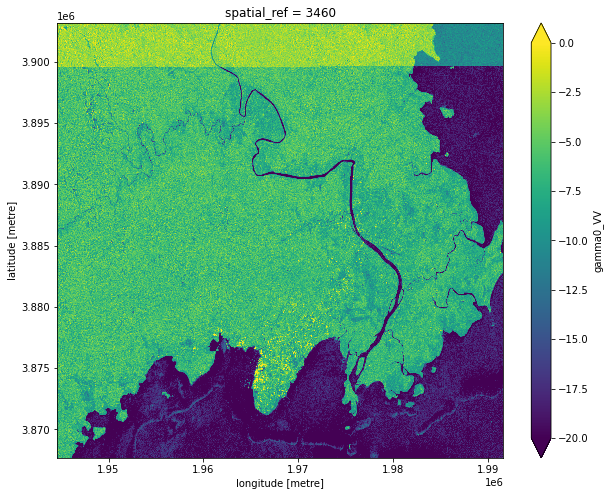

In [54]:
# jupyteronly
plt.figure(figsize = (10,8))
s1_composite.gamma0_VV.plot(vmin=-20, vmax=0)

### Export

In [55]:
ds = s1_composite.to_array()
ds = ds.compute()

In [56]:
#Export as Cog
write_cog(geo_im=ds,
          fname='s1composite.tif',
          overwrite=True)

PosixPath('s1composite.tif')

In [57]:
#write as tif
#write_geotiff_from_xr('s1_composite.tiff', s1_composite, crs=output_projection, bands=['vv', 'vh'], x_coord = 'longitude', y_coord = 'latitude')

In [58]:
#naming exports for ESRI to pick up
['s1composite.tif']

['s1composite.tif']

---